# Статистический анализ данных сервиса аренды самокатов GoFast


**Цель исследования**

Цель данного исследования состоит в том, чтобы на основе имеющихся данных о пользователях сервиса GoFast проверить некоторые гипотезы, которые позволят определить насколько осмысленно для сервиса развивать и продвигать платную подписку. В качестве входных данных нами будет использована информация о пользователях, их поездках и подписках, собранная по нескольким городам.    

**Описание данных**

Данные представлены следующими категориями:

Пользователи — users_go.csv

* user_id — уникальный идентификатор пользователя
* name — имя пользователя
* age — возраст
* city — город
* subscription_type — тип подписки (free, ultra)

Поездки — rides_go.csv

* user_id — уникальный идентификатор пользователя
* distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date — дата совершения поездки

Подписки — subscriptions_go.csv

* subscription_type — тип подписки
* minute_price — стоимость одной минуты поездки по данной подписке
* start_ride_price — стоимость начала поездки
* subscription_fee — стоимость ежемесячного платежа

**План исследования**

1. Загрузка данных

Загрузим данные и изучим общую информацию о каждом датафрейме. 

2. Предобработка данных

На данном этапе мы проверим нашу таблицу на наличие пропусков и дубликатов, скорректируем их и при необходимости добавим в таблицу новые столбцы.

3. Исследовательский анализ данных

На данном этапе мы опишем и визуализируем общую информацию о пользователях и поездках, в частности мы рассмотрим:

* частоту встречаемости городов;
* соотношение пользователей с подпиской и без подписки;
* возраст пользователей;
* расстояние, которое пользователь преодолел за одну поездку;
* продолжительность поездок.

4. Объединение данных

На данном этапе мы объединим данные о пользователях, поездках и подписках и визуализируем информацию о расстоянии и времени поездок для пользователей с подпиской и без подписки.

5. Подсчёт выручки

На данном этапе мы подсчитаем помесячную выручку, которую принёс каждый пользователь.

6. Проверка гипотез

На данном этапе мы проверим такие гипотезы как:

* "Пользователи с подпиской тратят больше времени на поездки"; 
* "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров"; 
* "Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки".

Рассмотрим какие тесты необходимы для проверки гипотезы "Количество обращений в техподдержку значимо снизилось после обновления сервера, с которыми взаимодействует мобильное приложение сервиса".

7. Распределения

В интересах отдела маркетинга сервиса построим графики распределения и выясним:

* "Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план акции с раздачей промокодов была примерно 5%";
* "Какова вероятность того, что из 1 млн. push-уведомлений откроют не более 399,5 тыс."

8. Выводы.



### Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')

In [3]:
data_rides = pd.read_csv('/datasets/rides_go.csv')

In [4]:
data_subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [5]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
data_subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


* Датафрейм data_users имеет 5 столбцов с целочисленными (2) и строковыми (3) типами данных, 1565 строк и размер в 61.3 кб. Столбец date потребуется в дальнейшем привести к типу даты pandas. 
* Датафрейм data_rides имеет 4 столбца с целочисленным (1), строковым (1) типами данных и типом данных для чисел с плавающей запятой (2), 18068 строк и размер в 564.8 кб. 
* Датафрейм data_subs имеет 4 столбца с целочисленными (3) и строковым (1) типами данных и типом данных для чисел с плавающей запятой (2), 2 строки и размер в 192 б. 

### Шаг 2. Предобработка данных

#### Приведем столбец date к типу даты pandas.

In [11]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')

In [12]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#### Создадим новый столбец с номером месяца на основе столбца date.

In [13]:
# Проверим действительно ли в датафрейме данные только за один год
data_rides['date'].dt.year.unique()

array([2021])

In [14]:
data_rides['month'] = data_rides['date'].dt.month

#### Проверим наличие пропущенных значений и дубликатов в датафреймах.

**Проверим датафрейм на наличие неявных дубликатов**

In [15]:
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Проверим данные на наличие пропущенных значений и дубликатов и обработаем их при необходимости.**

In [16]:
data_users.duplicated().sum()

31

In [17]:
data_users = data_users.drop_duplicates()

In [18]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [19]:
data_rides.duplicated().sum()

0

In [20]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

**В ходе предобработки данных было установлено, что в исходных данных отсутствуют пропуски, среди данных о пользователях (users_go.csv) имеется несколько дубликатов. Неявные дубликаты отсутствуют. Тип данных в столбце date был приведен к типу даты pandas. В целом предобработка данных не потребовала значительных усилий.**

### Шаг 3. Исследовательский анализ данных

#### Частота встречаемости городов.

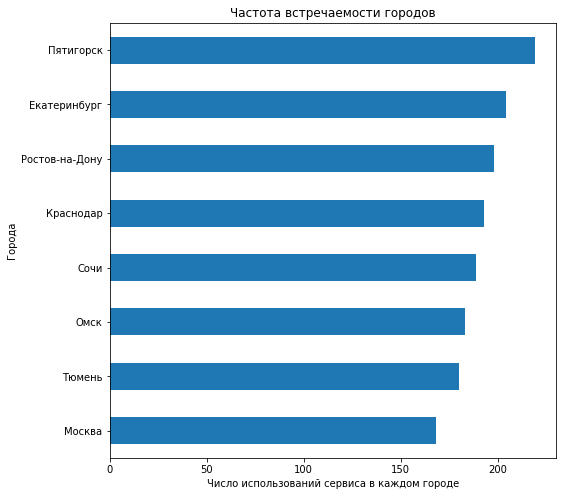

In [21]:
(data_users.groupby('city')['city'].agg('count').sort_values()
 .plot(kind='barh', figsize=(8, 8), title='Частота встречаемости городов', grid=False))
plt.xlabel('Число использований сервиса в каждом городе')
plt.ylabel('Города')
plt.show()

In [22]:
data_users.groupby('city')['city'].agg('count').sort_values(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

**Больше всего пользователей из Пятигорска (219), меньше всего - из Москвы (168).**

#### Соотношение пользователей с подпиской и без подписки.

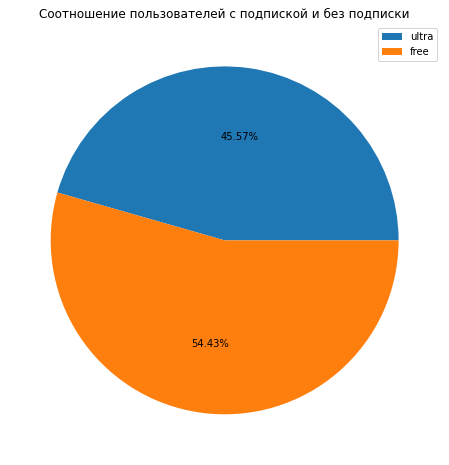

In [23]:
(data_users.groupby('subscription_type')['city'].agg('count').sort_values(ascending=True)
 .plot(kind='pie', labels=None, label='', autopct='%0.2f%%',
       legend=True, figsize=(8, 8), title='Соотношение пользователей с подпиской и без подписки'))
plt.show()

In [24]:
data_users.groupby('subscription_type')['subscription_type'].agg('count')

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64

**Число пользователей без подписки - 835 человек, что составляет 54.43% от общего числа пользователей. Число пользователей с подпиской - 699 человек или 45.57%.**

#### Возраст пользователей.

Text(0, 0.5, 'Число пользователей')

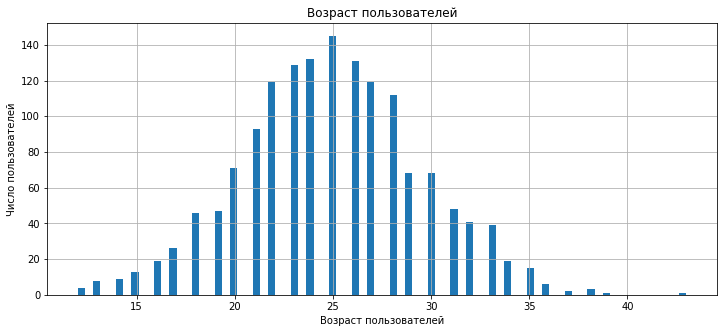

In [25]:
data_users['age'].hist(bins=80, figsize=(12, 5))
plt.title('Возраст пользователей')
plt.xlabel('Возраст пользователей')
plt.ylabel('Число пользователей')

Text(0.5, 1.0, 'Возраст пользователей')

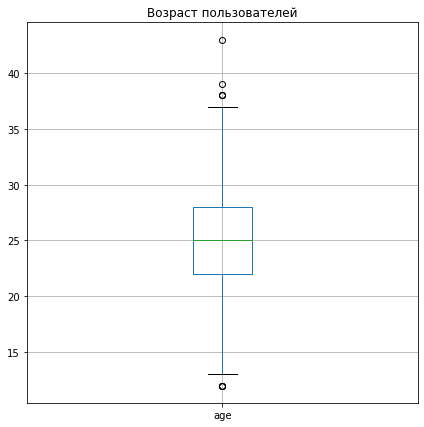

In [26]:
data_users.boxplot('age', figsize=(7, 7))
plt.title('Возраст пользователей')

In [27]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Возраст пользователей сервиса GoFast находится в диапазоне от 12 до 43 лет. Чаще всего встречается возраст 25 лет, он же является медианным.**

#### Расстояние, которое пользователь преодолел за одну поездку.

Text(0, 0.5, 'Число поездок')

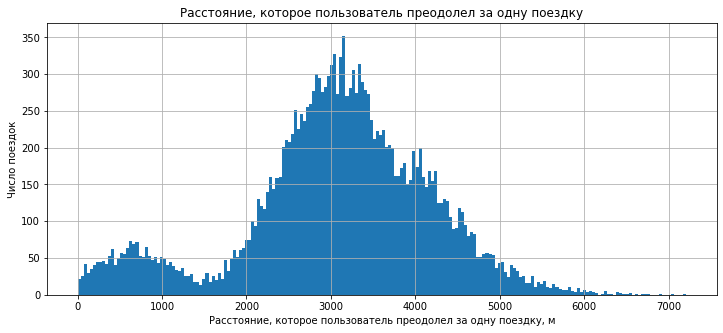

In [28]:
data_rides['distance'].hist(bins=200, figsize=(12, 5))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, которое пользователь преодолел за одну поездку, м')
plt.ylabel('Число поездок')

Text(0.5, 1.0, 'Расстояние, которое пользователь преодолел за одну поездку')

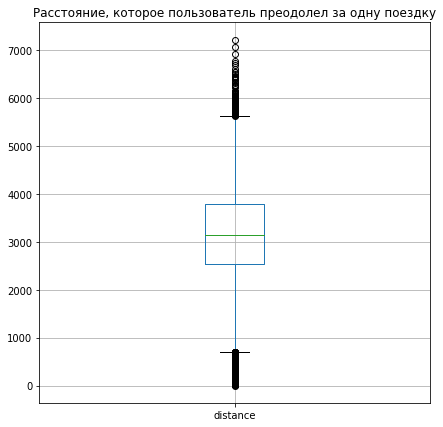

In [29]:
data_rides.boxplot('distance', figsize=(7, 7))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')

In [30]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**За одну поездку пользователи сервиса GoFast преодолевают расстояние в диапазоне от 0.85 до 7211 м. Медианное значение - 3133.6 м. Среднее значение - 3070.6 м. Также на гистограмме присутствует малый пик около 700 м.**

#### Продолжительность поездок.

Text(0, 0.5, 'Число поездок')

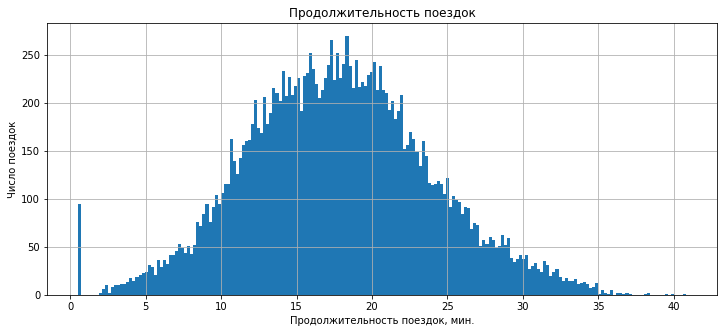

In [31]:
data_rides['duration'].hist(bins=200, figsize=(12, 5))
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездок, мин.')
plt.ylabel('Число поездок')

Text(0.5, 1.0, 'Продолжительность поездок')

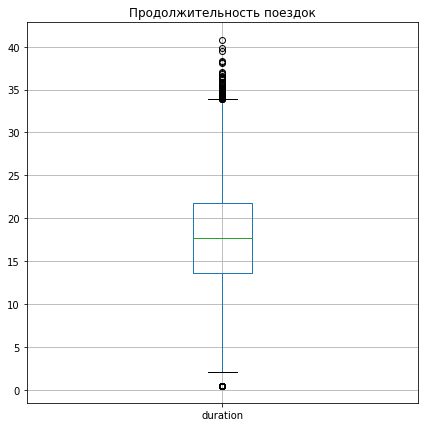

In [32]:
data_rides.boxplot('duration', figsize=(7, 7))
plt.title('Продолжительность поездок')

Text(0, 0.5, 'Число поездок')

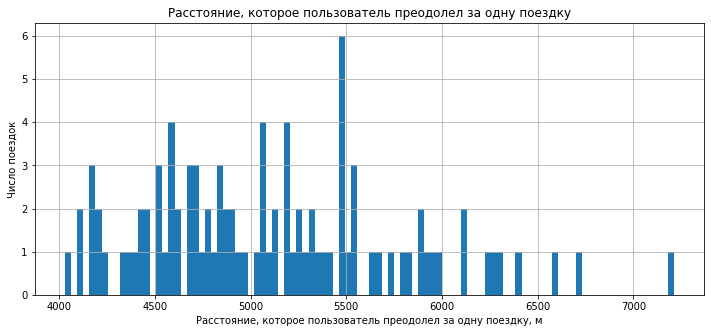

In [33]:
# Проверим какое расстояние соответствует поездке длительностью в полминуты.
data_rides[data_rides['duration'] == 0.5]['distance'].hist(bins=100, figsize=(12, 5))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, которое пользователь преодолел за одну поездку, м')
plt.ylabel('Число поездок')

In [34]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**Длительность одной поездки составляет от 0.5 до 40.8 мин. Медианное значение - 17.7 мин., что близко к среднему - 17.8 мин. Также на гистограмме присутствует малый пик около минимального значения в полминуты, вероятно вызвынный технической неполадкой в работе приложения, так как, чтобы преодолеть расстояние в 5 км за полминуты, самокат должен был бы иметь скорость в 600 км/ч.**

### Шаг 4. Объединение данных

#### Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [35]:
data = data_rides.merge(data_users, on='user_id').merge(data_subs, on='subscription_type')

In [36]:
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


**Сравним размеры датафреймов до и после объединения.**

In [37]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [38]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [39]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


То что размер итогового датафрейма заметно больше (1.8 мб) размера объединяемых датасетов (71.9 кб + 705.9 кб + 192 б) связано с тем, что столбцы name, age, city, и subscription_type увеличились с 1534 до 18068 строк, а столбцы minute_price, start_ride_price и subscription_fee с 2 до 18068 строк.

#### Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1.

In [41]:
# Для пользователей без подписки.
data_free = data[data['subscription_type'] == 'free']

In [42]:
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [43]:
# Для пользователей с подпиской.
data_ultra = data[data['subscription_type'] == 'ultra']

In [44]:
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


#### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

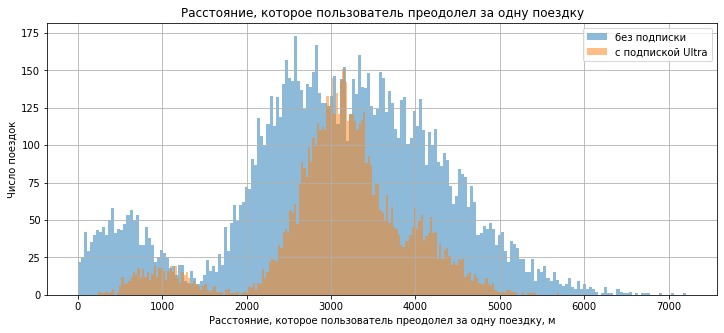

In [45]:
data_free.rename(columns = {'distance':'без подписки'})['без подписки'].hist(bins=200, figsize=(12, 5), alpha=0.5, legend=True)
(data_ultra.rename(columns = {'distance':'с подпиской Ultra'})['с подпиской Ultra']
 .hist(bins=200, figsize=(12, 5), alpha=0.5, legend=True))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, которое пользователь преодолел за одну поездку, м')
plt.ylabel('Число поездок')
plt.show()

In [46]:
data_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [47]:
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

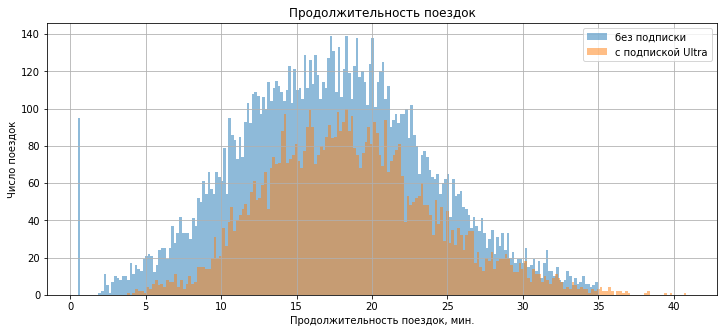

In [48]:
data_free.rename(columns = {'duration':'без подписки'})['без подписки'].hist(bins=200, figsize=(12, 5), alpha=0.5, legend=True)
(data_ultra.rename(columns = {'duration':'с подпиской Ultra'})['с подпиской Ultra']
 .hist(bins=200, figsize=(12, 5), alpha=0.5, legend=True))
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездок, мин.')
plt.ylabel('Число поездок')
plt.show()

In [49]:
data_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [50]:
data_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

**Пользователи без подписки чаще совершают поездки - 11568 против 6500 у пользователей с подпиской - почти в 2 раза чаще. При этом медианные значения преодоленного расстояния близки - 3114.6 и 3148.6 м, но при этом отличаются минимальные и максимальные значения - 0.85 и 244 м и 7211 и 5699.8 м соответственно для пользователей без подписки и с подпиской. Есть отличия и в длительности поездок - минимумы - 0.5 и 3.8 мин., максимумы - 35 и 40.8 мин., медианные значения - 17.3 и 18.2 мин. соответственно для пользователей без подписки и с подпиской.**

### Шаг 5. Подсчёт выручки

#### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4.

In [51]:
# Добавим столбец с округленными значениями длительности поездок, он понадобится в следующем пункте
data['duration_round'] = np.ceil(data['duration'])
# Создадим датафрейм с агрегированными данными
data_agg = data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration', 'duration_round', 'minute_price', 
                                                             'start_ride_price', 'subscription_fee'], 
                         aggfunc={'distance': 'sum',
                                  'duration': ['sum', 'count'],
                                  'duration_round': 'sum',
                                  'start_ride_price': 'mean',
                                  'subscription_fee': 'mean',
                                  'minute_price': 'mean'})
# Поправим заголовки столбцов
data_agg.columns = ['distance', 'count', 'duration', 'duration_round', 'minute_price', 'start_ride_price', 'subscription_fee']

In [52]:
# Проверим датафрейм с агрегированными данными на наличие пропусков
data_agg.isna().sum()

distance            0
count               0
duration            0
duration_round      0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

#### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [53]:
data_agg['monthly_revenue'] = data_agg['start_ride_price'] * data_agg['count'] + data_agg['minute_price'] * data_agg['duration_round'] + data_agg['subscription_fee']
data_agg.head()

distance  count   duration  duration_round  minute_price  \
user_id month                                                                
1       1      7027.511294      2  41.416640            42.0             6   
        4       754.159807      1   6.232113             7.0             6   
        8      6723.470560      2  44.776802            46.0             6   
        10     5809.911100      2  31.578017            32.0             6   
        11     7003.499363      3  53.397424            56.0             6   

               start_ride_price  subscription_fee  monthly_revenue  
user_id month                                                       
1       1                     0               199            451.0  
        4                     0               199            241.0  
        8                     0               199            475.0  
        10                    0               199            391.0  
        11                    0               199            535.0

### Шаг 6. Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки?

Гипотеза Н0: Средняя продолжительность поездок с подпиской и без подписки равна.

Гипотеза Н1: Средняя продолжительность поездок с подпиской больше, чем поездок без подписки.

In [54]:
alpha = 0.05 # уровень статистической значимости

# Выборки не равны, установим equal_var=False
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Вывод: Отвергаем нулевую гипотезу о том, что средняя продолжительность поездок с подпиской и без подписки равна в пользу гипотезы о том, что средняя продолжительность поездок с подпиской больше, чем поездок без подписки. Возможно пользователи с подпиской действительно тратят больше времени на поездки.

#### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Гипотеза Н0: Среднее расстояние, которое проезжают пользователи с подпиской, равно оптимальному расстоянию в 3130 метров.

Гипотеза Н1: Среднее расстояние, которое проезжают пользователи с подпиской, больше 3130 метров.

In [55]:
alpha = 0.05 # уровень статистической значимости

# Выборки не равны, установим equal_var=False
results = st.ttest_1samp(data_ultra['distance'], 3130, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Вывод: Не получилось отвергнуть нулевую гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской, равно оптимальному расстоянию в 3130 метров в пользу гипотезы о том, что среднее расстояние, которое проезжают пользователи с подпиской, больше 3130 метров. Возможно расстояние, которое проезжают пользователи с подпиской, действительно меньше или равно оптимальному. 

#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Гипотеза Н0: Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

Гипотеза Н1: Помесячная выручка от пользователей с подпиской по месяцам больше, чем выручка от пользователей без подписки.

In [56]:
alpha = 0.05 # уровень статистической значимости

# Выборки не равны, установим equal_var=False
results = st.ttest_ind(data_agg[data_agg['subscription_fee'] == 199]['monthly_revenue'], 
                       data_agg[data_agg['subscription_fee'] == 0]['monthly_revenue'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Вывод: Отвергаем нулевую гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки в пользу гипотезы о том, что помесячная выручка от пользователей с подпиской по месяцам больше, чем выручка от пользователей без подписки. Возможно имеет смысл продолжать продвигать подписку среди пользователей.  

#### Рассмотрим какие тесты необходимы для проверки гипотезы "Количество обращений в техподдержку значимо снизилось после обновления сервера, с которыми взаимодействует мобильное приложение сервиса".

Если размеры выборок равны, т.е. количество уникальных пользователей до и после обновления совпадает, следует использовать метод st.ttest_rel(). 

### Шаг 7. Распределения

#### Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план акции с раздачей промокодов была примерно 5%.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 1001 artists>

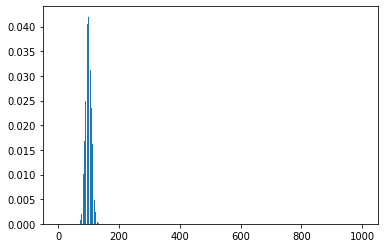

In [57]:
# Построим график распределения

n = 1000 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)

(25.0, 175.0)

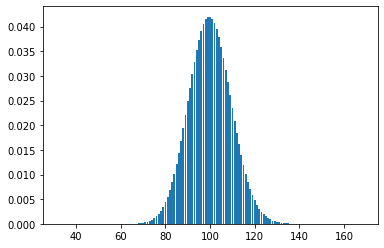

In [58]:
# Рассмотрим график на интересующем нас диапазоне

plt.bar(range(0, n + 1), distr)
plt.xlim(25, 175)

In [59]:
p = 0.1 # вероятность успеха

# Подберем такое количество промокодов, при котором вероятность не выполнить план будет < 5%

i = 1000
while binom(i, p).cdf(100) > 0.05:
    i += 1
else:
    print(f'Число промокодов: {i}, cdf= {binom(i, p).cdf(100)}')
       

Число промокодов: 1172, cdf= 0.04954795210203071


(25.0, 175.0)

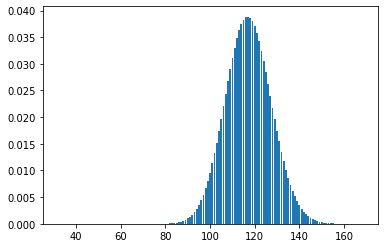

In [60]:
# Построим новый график распределения

n = 1172 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)

plt.xlim(25, 175)

Вывод: чтобы вероятность не выполнить план была примерно 5%, требуется разослать как минимум 1172 промокода

#### Какова вероятность того, что из 1 млн. push-уведомлений откроют не более 399,5 тыс.

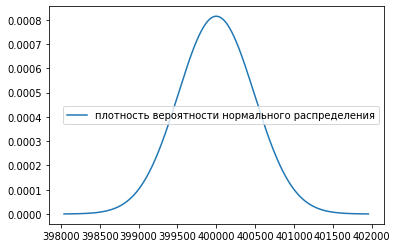

cdf= 0.15371708296369768


In [61]:
n = 1000000 # количество попыток
p = 0.4 # вероятность успеха

# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# зададим нормальное распределение
mu = n * p
sigma = sqrt(n * p * (1 - p))

# границы промежутка, в котором будем строить аппроксимацию
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = linspace(left, right, 1000000)

ax = plt.subplot()
ax.plot(x, norm.pdf(x, mu, sigma), label='плотность вероятности нормального распределения')
    
# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

distr = st.norm(mu, sigma)
print(f'cdf= {distr.cdf(399500)}') 

Вывод: вероятность того, что из 1 млн. уведомлений пользователеми будет открыто не более 399,5 тыс., составляет 15,37%. 

### Выводы

В ходе данного исследования нами был рассмотрен ряд гипотез:

**Тратят ли пользователи с подпиской больше времени на поездки?**

Отвергаем нулевую гипотезу о том, что средняя продолжительность поездок с подпиской и без подписки равна в пользу гипотезы о том, что средняя продолжительность поездок с подпиской больше, чем поездок без подписки. Возможно пользователи с подпиской действительно тратят больше времени на поездки. 

**Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Не получилось отвергнуть нулевую гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской, равно оптимальному расстоянию в 3130 метров в пользу гипотезы о том, что среднее расстояние, которое проезжают пользователи с подпиской, больше 3130 метров. Возможно расстояние, которое проезжают пользователи с подпиской, действительно меньше или равно оптимальному.

**Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**

Отвергаем нулевую гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки в пользу гипотезы о том, что помесячная выручка от пользователей с подпиской по месяцам больше, чем выручка от пользователей без подписки. Возможно имеет смысл продолжать продвигать подписку среди пользователей. 


Кроме того мы установили, что:

**Для того, чтобы вероятность не выполнить план маркетингового отдела была примерно 5%, требуется разослать как минимум 1172 промокода.**

**Вероятность того, что из 1 млн. уведомлений пользователеми будет открыто не более 399,5 тыс., составляет 15,37%**

**Итоговый вывод:** 

Исследование гипотез говорит нам о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального, что снижает износ самокатов; помесячная выручка среди пользователей с платной подпиской выше, чем у пользователей без подписки, что также говорит в ее пользу; пользователи с подпиской тратят больше времени на поездки. Таким образом можно утверждать, что для сервиса аренды самокатов GoFast имеет смысл далее развивать и продвигать платную подписку. 